In [ ]:
# import libaries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import pad
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# laod the dataset
df = pd.read_csv('big_dataset.csv')
print(df.shape)
df.head()

(22408, 3)


,clean_tweet,emotion,label
0,time ticking fast relive past happy joy face,happy,3
1,happy birthday one hot love much amazing frien...,happy,3
2,best cheer left min cant save happy like treas...,happy,3
3,good morning wishing day filled sunshine happi...,happy,3
4,eric movie made happy several way think rely s...,happy,3


In [ ]:
# drop the null values
df = df.dropna(axis=0)
df.isna().sum()

clean_tweet    0
emotion        0
label          0
dtype: int64

In [ ]:
df['length'] = df.clean_tweet.apply(lambda x: len([s for s in x.split()]))
df['label'] = df.label.apply(int)
df.head()

,clean_tweet,emotion,label,length
0,time ticking fast relive past happy joy face,happy,3,8
1,happy birthday one hot love much amazing frien...,happy,3,19
2,best cheer left min cant save happy like treas...,happy,3,12
3,good morning wishing day filled sunshine happi...,happy,3,17
4,eric movie made happy several way think rely s...,happy,3,18


In [ ]:
# create vocab
vocab = {word: i+1 for i, word in enumerate(set(' '.join(df['clean_tweet']).split()))}
len(vocab)

15797

In [ ]:
# check unique vocab
df.label.unique()

array([3, 4, 0, 2, 1, 5])

In [ ]:
# hyperparameters
embedding_dim = 128
hidden_dim = 256
num_layers = 2
num_classes = 6
batch_size = 512

In [ ]:
# create tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.clean_tweet.to_list())
word_index = tokenizer.word_index
len(word_index)

15797

In [ ]:
# tokenize text and do pedding
x =  tokenizer.texts_to_sequences(df.clean_tweet.to_list())
x = pad_sequences(x, maxlen=20, padding='post', truncating='post')
y = df.label.values
print(x.shape)
print(y.shape)

(22408, 20)
(22408,)


Text(0.5, 0, 'length of sentence')

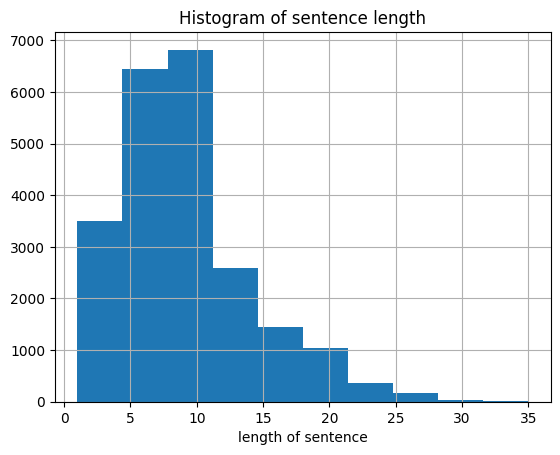

In [108]:
df.length.hist()
plt.title("Histogram of sentence length")
plt.xlabel("length of sentence")

In [ ]:
for i in range(5):
  print(x[i])

[   6 6236  873 5054  172   27  254  152    0    0    0    0    0    0
    0    0    0    0    0    0]
[ 27 402  12 955  24  26 115  58 874 408  36   3 559 936   7 210 640  36
 836   0]
[  82  545   93 2389   55  875   27    3 3456  121    6   27    0    0
    0    0    0    0    0    0]
[  25  130 1051   11  956 1864  268   24  546  876   11 3817   92 1865
   38  290   27    0    0    0]
[2236  354   45   27 1094   21   18 2921  356 4319 8508 2390  176  218
  170  763  877 4320    0    0]


In [ ]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state=21, stratify=y)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(17926, 20)
(17926,)
(4482, 20)
(4482,)


In [ ]:
# create LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(vocab), output_dim=128))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(256, dropout=0.6, recurrent_dropout=0.6))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(6, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 128)         2022016   
                                                                 
 spatial_dropout1d_7 (Spatia  (None, None, 128)        0         
 lDropout1D)                                                     
                                                                 
 lstm_7 (LSTM)               (None, 256)               394240    
                                                                 
 dense_21 (Dense)            (None, 100)               25700     
                                                                 
 dropout_14 (Dropout)        (None, 100)               0         
                                                                 
 dense_22 (Dense)            (None, 6)                 606       
                                                      

In [ ]:
# train the model
history = model.fit(X_train, y_train, epochs=30, validation_split=0.1, batch_size=512, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/30
32/32 [==============================] - 8s 258ms/step - loss: 1.4817 - accuracy: 0.3627 - val_loss: 1.4476 - val_accuracy: 0.3681
Epoch 2/30
32/32 [==============================] - 9s 273ms/step - loss: 1.3643 - accuracy: 0.3831 - val_loss: 1.1918 - val_accuracy: 0.4283
Epoch 3/30
32/32 [==============================] - 6s 178ms/step - loss: 1.2103 - accuracy: 0.4288 - val_loss: 1.0888 - val_accuracy: 0.4802
Epoch 4/30
32/32 [==============================] - 8s 236ms/step - loss: 1.1125 - accuracy: 0.4721 - val_loss: 1.0786 - val_accuracy: 0.4752
Epoch 5/30
32/32 [==============================] - 9s 280ms/step - loss: 1.0558 - accuracy: 0.5121 - val_loss: 1.0124 - val_accuracy: 0.5683
Epoch 6/30
32/32 [==============================] - 12s 351ms/step - loss: 1.0087 - accuracy: 0.5484 - val_loss: 0.9708 - val_accuracy: 0.6051
Epoch 7/30
32/32 [==============================] - 9s 299ms/step - loss: 0.9368 - accuracy: 0.6060 - val_loss: 0.9159 - val_accuracy: 0.6297
Epoch

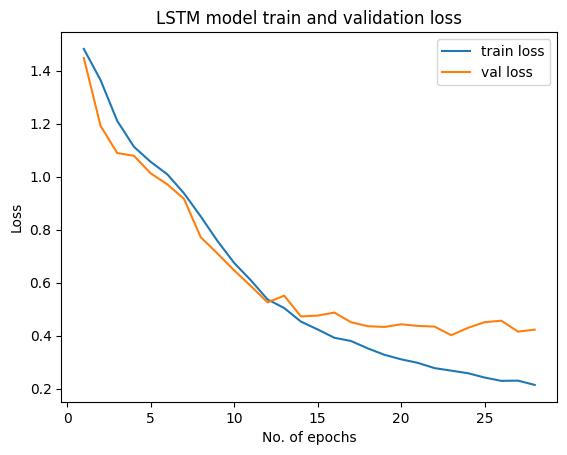

In [ ]:
# get loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(range(1, 29), train_loss, label='train loss')
plt.plot(range(1, 29), val_loss, label='val loss')
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("LSTM model train and validation loss")
plt.show()

In [ ]:
# model prediction on test set
y_pred = model.predict(X_test)
y_pred = [np.argmax(y) for y in y_pred]
report = classification_report(y_pred, y_test)
print(report)

141/141 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       593
           1       0.81      0.93      0.86        96
           2       0.83      0.85      0.84       489
           3       0.93      0.90      0.92      1758
           4       0.91      0.90      0.90      1396
           5       0.70      0.77      0.73       150

    accuracy                           0.89      4482
   macro avg       0.83      0.87      0.85      4482
weighted avg       0.89      0.89      0.89      4482



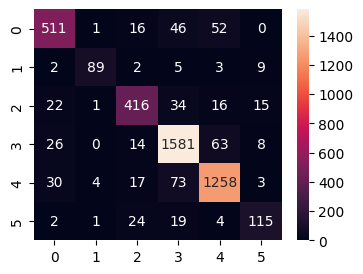

In [97]:
# confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f')
plt.show()

In [98]:
  # save the mode;
model.save("/content/drive/MyDrive/IR Project/LSTM_model.h5")
print("model saved")

model saved


In [101]:
# load the saved model
loaded_model = keras.models.load_model("/content/drive/MyDrive/IR Project/LSTM_model.h5")
loaded_model